In [57]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pystan
import os

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

import itertools
colours = itertools.cycle(('r', 'orange', 'olive', 'teal', 'sienna', 'indigo', 'k', 'c', 'm'))

In [58]:
#Import output data
output = pd.read_csv('../data/output_back_filesremoved.csv', usecols=[1,11,24])
#IDs = [(output.loc[output['ID'] == random.choice(output['ID'])]).iloc[0]['Numax'] for i in range(5)]
df_met = pd.read_csv('../data/APOKASCfull.csv')

#Set numax range so stars are chosen with similar size echelles
rng = 30
numax_tgt = 75
output = output.loc[(np.abs(output['numax'] - numax_tgt) < rng)].reset_index(drop=True)

#Number of stars to model
nStars = 100

#Selects a random sample of stars from the file, recording their IDs and makes sure the stars exist in APOKASC file
IDs = []*nStars
i = 0
while i < nStars:
    nextID = random.choice(output['kic'])
    for j in range(len(df_met.KIC)):
        if nextID == df_met.KIC[j]:
            IDs.append(nextID)
            i += 1
#IDs = [random.choice(output['kic']) for i in range(nStars)]

# Create a list of the numax values and errors corresponding to each ID
Numax = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax'] for i in range(len(IDs))]
Numax_err = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax_err'] for i in range(len(IDs))]

print(IDs)

[9353187, 10480806, 9291249, 10659842, 11136854, 4570120, 10483504, 10420822, 9346602, 9080407, 1433593, 9100444, 6425301, 10224100, 10991271, 7346442, 7430868, 9790050, 10483504, 3424105, 9028321, 7346365, 10159217, 4937770, 9328135, 9409513, 11342694, 10864711, 9291830, 10792949, 10207321, 11295851, 10416550, 4140726, 3545147, 9968249, 10482001, 8824452, 8350645, 10983401, 11134982, 10161943, 4241369, 4241369, 10866415, 9077844, 10287323, 10420822, 2831788, 12003742, 10482001, 3444374, 3455760, 5940060, 9583720, 10161943, 11509277, 8872979, 4760954, 6929729, 4241369, 9579860, 10935853, 11513798, 10220795, 6756648, 10095427, 10592924, 9970467, 5200152, 11043832, 11129945, 9406415, 9968249, 2834230, 4937770, 11441797, 5023889, 10006852, 9229601, 9100444, 9941141, 10162765, 2140446, 10224100, 9335518, 9835790, 6929729, 2831788, 10816214, 10592924, 6764229, 9711231, 9535050, 10157507, 11287679, 10991271, 10416550, 9346602, 10229796]


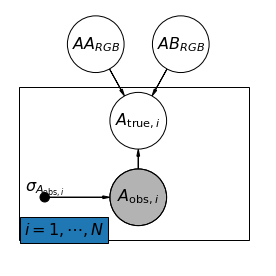

In [59]:
#Create acyclic graph (probabalistic graphical model)
from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=3, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("AA", r"$AA_{RGB}$", 1.0, 2.6))
pgm.add_node(daft.Node("AB", r"$AB_{RGB}$", 2.0, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("A_true", r"$A_{{\rm true},i}$", 1.5, 1.7))
# Data.
pgm.add_node(daft.Node("A_obs", r"$A_{{\rm obs},i}$", 1.5, 0.8, observed=True))
pgm.add_node(daft.Node("Aerr", r"$\sigma_{A_{{\rm obs},i}}$", 0.4, 0.8, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("AA", "A_true")
pgm.add_edge("AB", "A_true")
pgm.add_edge("A_obs", "A_true")
pgm.add_edge("Aerr", "A_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

In [60]:
#Import mode data and construct arrays for storing orders and frequencies
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0']) for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)
arr_n = np.zeros([len(IDs),maxmodes])
arr_freq = np.zeros([len(IDs),maxmodes])
arr_freqerr = np.zeros([len(IDs),maxmodes])

#Sort values by frequency and assign order and calculate avg dnu
dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    #(due to some stars having fewer mode frequencies observed)
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 100000}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            #modesID[i].loc[l] = [l, int(np.max(modesID[i]['n']+l)), (np.max(modesID[i]['dnu'])+dnu_avgID[i]), np.nan , 10000]
            #app = pd.DataFrame([(np.max(modesID[i]['dnu'])+dnu_avgID[i]), 10000], columns=['n', 'f0', 'f0_err'])
            #modesID[i].append(app, ignore_index=True)
            l += 1
        
    arr_n[i,:] = modesID[i]['n']
    arr_freq[i,:] = modesID[i]['f0']
    arr_freqerr[i,:] = modesID[i]['f0_err']
    
    #display(modesID[i])
dnu_avgarr = np.asarray(dnu_avgID)

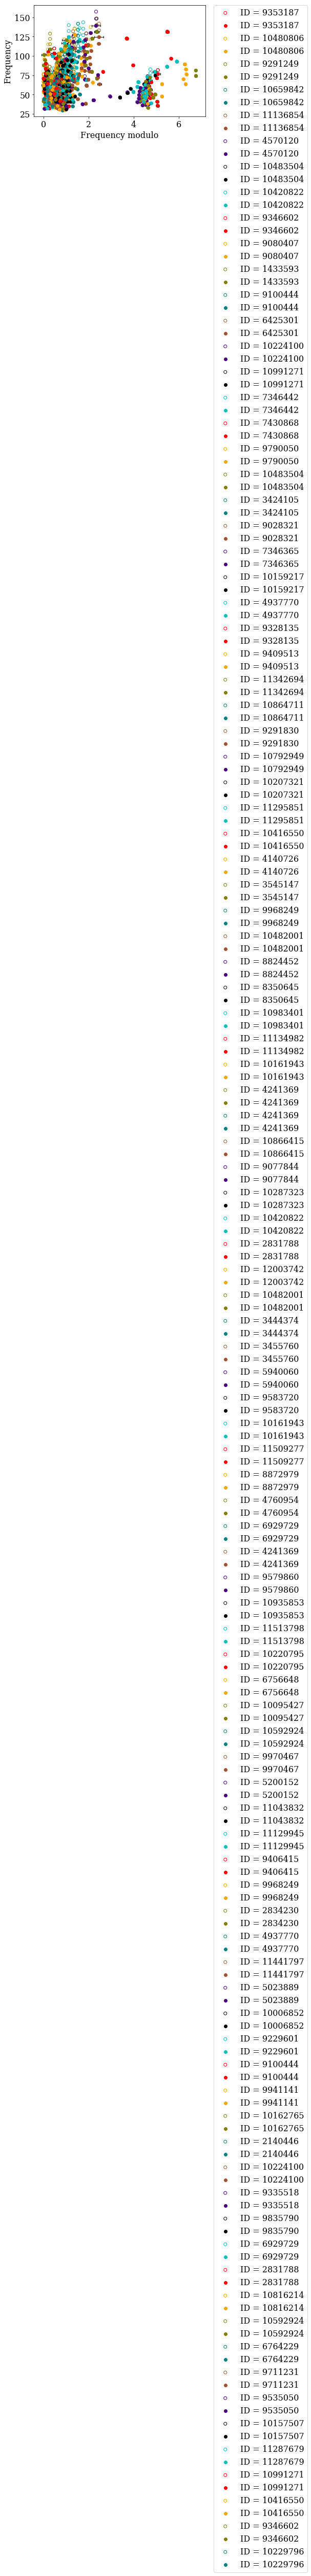

In [61]:
#Construct and plot echelles for each star
for i in np.arange(0,len(IDs),1):
    # Iterate point colour
    colour = next(colours)
    # Plot all frequencies, and errorbars for the 'true' data
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label=r'ID = '+str(IDs[i]), zorder=-1, facecolors='none', edgecolors=colour)
    pts = modesID[i].loc[(modesID[i]['f0_err'] < 10e3)]
    plt.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'ID = '+str(IDs[i]), c=colour)
    plt.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)
#for i in np.arange(0,len(IDs),1):
    #plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

#Define start parameters
eps = []
for i in range(len(IDs)):
    epsilon1 = np.median((modesID[i].f0 % dnu_avg) / dnu_avg)
    eps.append(epsilon1)
epsilon = np.asarray(eps)

numax_obs = Numax
numax_err = Numax_err
nmax = numax_obs/dnu_avgarr - epsilon
alpha = 0.015*dnu_avgarr**(-0.32)
#A = 0.06*dnu_avgarr**(-0.88) 
A = 0.06*dnu_avgarr**(-0.88)
G = np.ones([len(IDs)])*3.08
tau = np.ones([len(IDs)])*10
phi = np.ones([len(IDs)])*1.71

plt.ylabel('Frequency')
plt.xlabel(r'Frequency modulo')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

$A_{n_{max}} = A_0 e^{-\frac{n}{\tau}}$

Rearrange for A0 is transformed parameter

In [42]:
code = '''
functions{
    real asex(real n, real dnu, real nmax, real epsilon, real alpha, real A0, real G, real phi, real tau){
        return (n + epsilon + (alpha/2) * (nmax - n)^2 + 
                A0*G/(2*pi()) * sin((2*pi()*(n-nmax))/G + phi))*dnu
                *exp(-n/tau);
    }
}
data {
    int N;  //number of stars
    int M; //number of modes
    real n[N, M]; //order
    real freq[N, M]; //mode frequency
    real freq_err[N, M]; //uncertainty in mode frequency
    real dnu_guess[N];  //calculated estimate of dnu
    real numax_obs[N];  //calculated numax from data
    real numax_err[N];  //error in numax
}
parameters {
    real dnu[N];
    real<lower = 0> numax[N];
    
    real epsilon[N];
    real epsilon_std[N];
    real<lower = 0> eps_sig;
    real epsA;
    real epsB;
    
    real alpha_std[N];
    real<lower = 0> al_sig;
    real alA;
    real alB;
    
    //real A_std[N];
    //real<lower = 0> A_sig;
    real<lower = 0> Anmax[N];
    //real AA;
    //real AB;
    
    real<lower = 0> G[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];
    real<lower = 0> tau[N];
    
}

transformed parameters{
    //real epsilon[N];
    real alpha[N];
    real A0[N];
    //real A[N];
    for (i in 1:N){
        //epsilon[i] = epsilon_std[i] * eps_sig + (epsA + epsB * log(dnu[i]));
        alpha[i] = alpha_std[i] * al_sig + (alA * (dnu[i])^(-alB));
        //A[i] = A_std[i] * A_sig + (AA*dnu[i]^(-AB));
        A0[i] = Anmax[i] * exp((numax[i]/dnu[i] - epsilon[i])/tau[i]);
    }
}
model {
    real mod[M];
    real nmax[N];
    //real A0[N];
    //real A[N];
    for (i in 1:N){
        nmax[i] = numax[i]/dnu[i] - epsilon[i];
        //A0[i] = A[i]*exp(nmax[i]/tau[i]);
        for (j in 1:M){
            mod[j] = asex(n[i,j], dnu[i], nmax[i], epsilon[i], alpha[i], A0[i], G[i], phi[i], tau[i]);
            //mod[j] ~ normal(freq[i], freq_err[i]);
        }
        freq[i,:] ~ normal(mod, freq_err[i,:]);
        numax[i] ~ normal(numax_obs[i], numax_err[i]);
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.01);
        epsilon[i] ~ normal(0.601 + 0.632*log(dnu[i]), 0.5);
        //epsilon[i] ~ normal(epsA + epsB*log(dnu[i]), 0.5);
        //alpha[i] ~ lognormal(log(alA*dnu[i]^(-alB)), 0.3);
        //A0[i] ~ lognormal(log(AA*dnu[i]^(-AB)), 0.4);
        //A[i] ~ lognormal(log(A0[i]*exp(nmax[i]/tau[i])), 0.4);
        Anmax[i] ~ normal(0.001, 0.03);
        epsilon[i] ~ uniform(-1.0, 2.0);
        //alpha[i] ~ lognormal(log(0.015*dnu[i]^(-0.32)), 0.5);
        A0[i] ~ lognormal(log(0.06*dnu[i]^(-0.88)), 0.6);
    }
    nmax ~ normal(10, 4);
    G ~ normal(3.08, 0.65);
    tau ~ normal(30, 10);
    epsilon_std ~ normal(0, 1);
    eps_sig ~ normal(0, 0.5);
    //epsA ~ normal(0.601, 0.08);
    //epsB ~ normal(0.632, 0.08);
    alpha_std ~ normal(0, 1);
    al_sig ~ normal(0, 0.5); 
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    //A_std ~ normal(0, 1);
    //A_sig ~ normal(0, 0.5);
    //AA ~ normal(0.06, 0.01);
    //AB ~ normal(0.88, 0.05);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_272110b55b6e508972313ddb5b4c5922 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmp8f0ixnlb/stanfit4anon_model_272110b55b6e508972313ddb5b4c5922_1638779075454142032.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


KeyboardInterrupt: 

Epsilon and A/A0 not hierarchical

In [23]:
stan_data = {'N': len(IDs),
         'M': maxmodes,
         'n': arr_n, 
         'freq': arr_freq,
         'freq_err': arr_freqerr,
         'dnu_guess': dnu_avgarr,
         'numax_obs': numax_obs,
         'numax_err': numax_err
        }
start = {'dnu': dnu_avgarr,
         'nmax': nmax,
         'numax': numax_obs,
         'epsilon': epsilon,
         'alpha': alpha,
         'A0': A,
         'A': 0.0001*np.ones([len(IDs)]),
         'eps_sig': 0.01,
         'al_sig': 0.01,
         'A_sig': 0.01,
         'G': G,
         'tau': tau,
         'phi': phi,
         'epsA': 0.601,
         'epsB': 0.632,
         'alA': 0.015,
         'alB': 0.32,
         'AA': 0.06,
         'AB': 0.88
        }
nchains = 4

fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

In [24]:
print(fit)

Inference for Stan model: anon_model_272110b55b6e508972313ddb5b4c5922.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[1]           8.02  8.5e-4   0.04   7.95   7.99   8.01   8.04   8.09   1811   1.01
dnu[2]           6.49  3.8e-4   0.03   6.44   6.47   6.49   6.51   6.55   5429    1.0
dnu[3]           5.12    0.08   0.12   4.86    5.1   5.18    5.2   5.24      2    4.2
dnu[4]            7.2  3.5e-4   0.03   7.14   7.18    7.2   7.22   7.27   8789    1.0
dnu[5]           8.81  7.6e-3   0.04   8.74   8.79   8.81   8.84   8.89     27   1.05
numax[1]        85.48    0.02   0.46  84.59  85.16  85.48  85.79  86.39    357   1.02
numax[2]        54.57  1.8e-3   0.19  54.21  54.45  54.57   54.7  54.93  11097    1.0
numax[3]        49.91    0.19   0.39  49.12  49.64  49.92  50.19  50.63      4   1.37
numax[4]        70.14    0.05   0.47

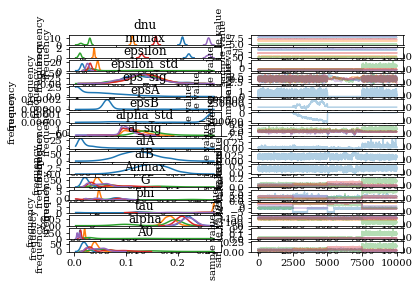

In [25]:
fit.plot()
plt.show()

In [34]:
def model(n, dnu, numax, epsilon, alpha, A, G, phi, tau):
    nmax = numax/dnu - epsilon
    freqs = (n + epsilon + (alpha/2) * (n - nmax)**2 + ((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi)) * dnu * np.exp(-n/tau)
    return freqs

def noglitch(n, dnu, numax, epsilon, alpha):
    nmax = numax/dnu - epsilon
    freqs = (n + epsilon + (alpha/2)*(n-nmax)**2)*dnu
    return freqs

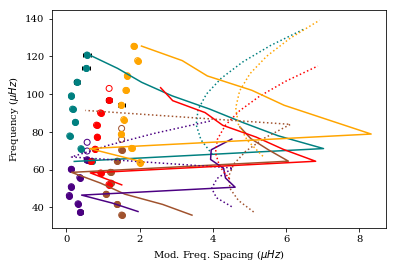

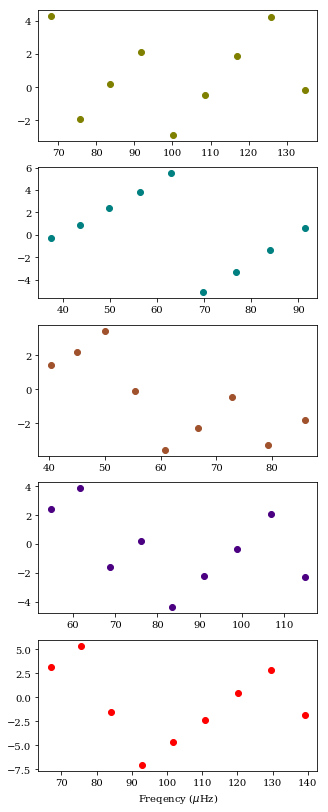

In [35]:
%matplotlib inline
    
g2s = []
g1s = []
for i in np.arange(0,len(IDs),1):
    # Iterate point colour
    colour = next(colours)
    # Plot all frequencies, and errorbars for the 'true' data
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label='', zorder=-1, facecolors='none', edgecolors=colour)
    pts = modesID[i].loc[(modesID[i]['f0_err'] < 10e3)]
    plt.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'ID = '+str(IDs[i]), c=colour)
    plt.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)
    g1 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          np.mean(fit['A0'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], np.mean(fit['tau'], axis=0)[i]) #np.mean(fit['tau'], axis=0)[i])
    g1s.append(g1)
    plt.plot(g1 % np.mean(fit['dnu'],axis=0)[i], g1, label='Fit_2D', c=colour)
    
    g2 = noglitch(arr_n[i], np.mean(fit['dnu'], axis=0)[i], np.mean(fit['numax'], axis=0)[i],
                       np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i])
    g2s.append(g2)
    plt.plot(g2 % np.mean(fit['dnu'],axis=0)[i], g2, label='Fit_2D', c=colour, linestyle=':')

plt.ylabel('Frequency ($\mu Hz$)')
plt.xlabel(f'Mod. Freq. Spacing ($\mu Hz$)')
#plt.xlim(-1,5)
plt.show()

fig, ax = plt.subplots(len(IDs), figsize=(5,14))
for i in np.arange(0,len(IDs),1):
    ax[i].scatter(g2s[i], (g2s[i] % dnu_avgID[i])-(g1s[i] % np.mean(fit['dnu'], axis=0)[i]), c=next(colours))
plt.xlabel(r'Freqency ($\mu$Hz)')
plt.show()

#Plot stan fitted model on echelle
#for i in range(len(IDs)):
    #plt.figure(len(IDs))
    #plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    #np.mean(modesID[i]['dnu'])
    #g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          #np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], 33) #np.mean(fit['tau'], axis=0)[i])
    #plt.plot(g2 % np.mean(fit['dnu'],axis=0)[i], g2, label='Fit_2D')

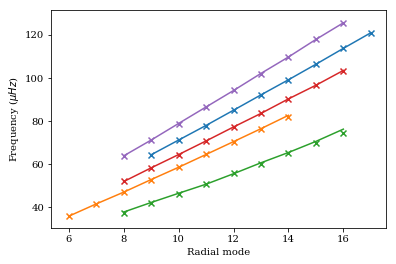

In [36]:
#Plot stan fitted model for freq vs n
for i in range(len(IDs)):
    plt.figure(len(IDs))
    plt.scatter(modesID[i]['n'], modesID[i]['f0'], marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    #np.mean(modesID[i]['dnu'])
    g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          np.mean(fit['A0'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], np.mean(fit['tau'], axis=0)[i])
    plt.plot(arr_n[i], g2, label='Fit_2D')

plt.ylabel('Frequency ($\mu Hz$)')
plt.xlabel(f'Radial mode')
plt.show()

Text(0.5, 0.98, 'Parameters plotted against $\\langle \\Delta \\nu \\rangle$')

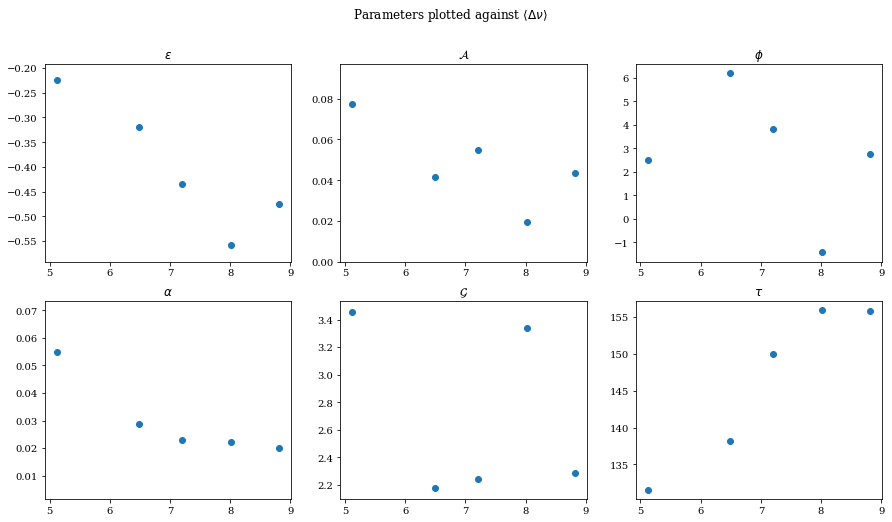

In [29]:
#Plot stan deduced parameters against dnu
dnus = []
numaxs = []
epsilons = []
alphas = []
As = []
Gs = []
phis = []
taus = []
for i in range(len(IDs)):
    dnus.append(np.mean(fit['dnu'],axis=0)[i])
    numaxs.append(np.mean(fit['dnu'],axis=0)[i])
    epsilons.append(np.mean(fit['epsilon'],axis=0)[i])
    alphas.append(np.mean(fit['alpha'],axis=0)[i])
    As.append(np.mean(fit['A0'],axis=0)[i])
    Gs.append(np.mean(fit['G'],axis=0)[i])
    phis.append(np.mean(fit['phi'],axis=0)[i])
    taus.append(np.mean(fit['tau'],axis=0)[i])
    
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False, sharex=False)
axs[0,0].scatter(dnus, epsilons)
axs[0,0].set_title(r'$\epsilon$')
axs[1,0].scatter(dnus, alphas)
axs[1,0].set_title(r'$\alpha$')
axs[0,1].scatter(dnus, As)
axs[0,1].set_title(r'$\mathcal{A}$')
axs[1,1].scatter(dnus, Gs)
axs[1,1].set_title(r'$\mathcal{G}$')
axs[0,2].scatter(dnus, phis)
axs[0,2].set_title(r'$\phi$')
axs[1,2].scatter(dnus, taus)
axs[1,2].set_title(r'$\tau$')
fig.suptitle(r'Parameters plotted against $\langle \Delta \nu \rangle$')

Text(0.5, 1.0, 'Period vs frequency of max power ($\\nu_{max}$)')

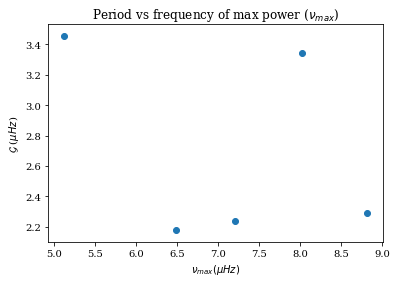

In [30]:
plt.scatter(numaxs, Gs)
plt.xlabel(r'$\nu_{max} (\mu Hz)$')
plt.ylabel(r'$\mathcal{G}$ ($\mu Hz$)')
plt.title(r'Period vs frequency of max power ($\nu_{max}$)')

Text(0, 0.5, 'Glitch amplitude ($\\mu Hz$)')

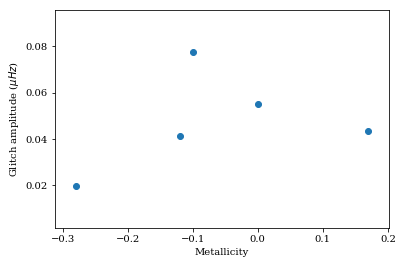

In [31]:
#Plot glitch amplitude against metallicity from APOKASC catalogue
df_met = pd.read_csv('../data/APOKASCfull.csv')
#metals = [(df_met.loc[(df_met['KIC'] == IDs[i])]).loc['[M/H]2'] for i in range(len(IDs))]


#metals = df_met.loc[(df_met['KIC'].isin(IDs))].reset_index(drop=True)

frames = []
for i in range(len(IDs)):
    mets = df_met.loc[df_met['KIC'] == IDs[i]]
    frames.append(mets)

metsall = pd.concat(frames).reset_index(drop=True)

IDdf = pd.DataFrame(IDs)
#ind = IDdf[~IDdf.isin(metsall['KIC'])]

#print(ind)
#print(metsall['KIC'])
#print(IDs)

plt.scatter(metsall['[M/H]2'].values, As)
plt.xlabel('Metallicity')
plt.ylabel('Glitch amplitude ($\mu Hz$)')